In [1]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, make_scorer

from sklearn.feature_selection import SequentialFeatureSelector

import matplotlib.pyplot as plt
from sklearn.svm import SVC
import pandas as pd
from time import time
from copy import deepcopy

In [2]:
# load features labels
with open('human+activity+recognition+using+smartphones/UCI HAR Dataset/features.txt') as file:
    features_labels = [line.strip().split()[1] for line in file.readlines()]

# load target class labels
with open('human+activity+recognition+using+smartphones/UCI HAR Dataset/activity_labels.txt') as file:
    target_class_labels = [line.strip().split()[1] for line in file.readlines()]

# Load the train set from txt files
X_train_file_path = 'human+activity+recognition+using+smartphones/UCI HAR Dataset/train/X_train.txt'
y_train_file_path = 'human+activity+recognition+using+smartphones/UCI HAR Dataset/train/y_train.txt'
X_train = pd.read_csv(X_train_file_path, header=None, delim_whitespace=True)
X_train.columns = features_labels
y_train = pd.read_csv(y_train_file_path, header=None, delim_whitespace=True).squeeze('columns')
y_train.name = 'target_class'


# Load the test set from txt files
X_test_file_path = 'human+activity+recognition+using+smartphones/UCI HAR Dataset/test/X_test.txt'
y_test_file_path = 'human+activity+recognition+using+smartphones/UCI HAR Dataset/test/y_test.txt'
X_test = pd.read_csv(X_test_file_path, header=None, delim_whitespace=True)
X_test.columns = features_labels
y_test = pd.read_csv(y_test_file_path, header=None, delim_whitespace=True).squeeze("columns")
y_test.name = 'target_class'


# creation of a report dataframe
report_series = list()
timings_series = list()

In [3]:
# counts in each class 
pd.concat([pd.DataFrame(target_class_labels, columns=['activity_label'], index=range(1,7)),
           y_train.value_counts().sort_index()], axis=1).rename(columns={'target_class':'counts'})

,activity_label,counts
1,WALKING,1226
2,WALKING_UPSTAIRS,1073
3,WALKING_DOWNSTAIRS,986
4,SITTING,1286
5,STANDING,1374
6,LAYING,1407


In [4]:
# checking for missing values
X_train.columns[X_train[X_train.isna()].any()]

Index([], dtype='object')

Text(0, 0.5, 'frequency')

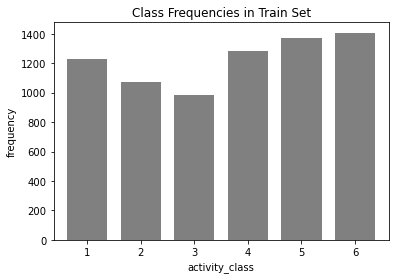

In [5]:
y_train.value_counts().sort_index().plot(kind='bar', color='grey', rot=0, title='Class Frequencies in Train Set', width=0.75)
plt.xlabel('activity_class')
plt.ylabel('frequency')


In [7]:
# initialization of models
models = [('svm_model', SVC(C=1, kernel='linear', gamma='auto'))]
models_pca = [(model_name + '_pca', model) for model_name, model in deepcopy(models)]
selectors_wrapping_models = [(model_name + "_wrapping_seq",
                              SequentialFeatureSelector(estimator=model,
                                                        direction='backward',
                                                        n_features_to_select='auto',
                                                        tol= -0.5,
                                                        scoring=make_scorer(balanced_accuracy_score),
                                                        n_jobs=-1), 
                              model) for model_name, model in deepcopy(models)]

In [8]:
for model_name, model in models:
    start_time_train = time()
    model.fit(X_train, y_train)
    end_time_train = time()
    
    start_time_test = time()
    y_pred = model.predict(X=X_test)
    end_time_test = time()
    metrics = {
        'accuracy': accuracy_score(y_true=y_test, y_pred=y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true=y_test, y_pred=y_pred),
        'f1_score': f1_score(y_true=y_test, y_pred=y_pred, average='macro'),
        'precision': precision_score(y_true=y_test, y_pred=y_pred, average='macro'),
        'training_time':end_time_train - start_time_train,
        'predicting_time':end_time_test - start_time_test
               }
    report_series.append(pd.Series(data=metrics, name=model_name))
    


In [9]:
pd.DataFrame(report_series)

,accuracy,balanced_accuracy,f1_score,precision,training_time,predicting_time
svm_model,0.964031,0.963589,0.964198,0.965895,0.507859,0.278354


In [9]:
n_pca_dict = {}
for i in range(X_test.shape[1]):
    # Create a PCA instance with desired number of components
    pca = PCA(n_components=i)  # You can specify the number of components you want

    # Fit the data to the PCA model
    pca.fit(X_train)

    # Transform the data into the new reduced dimensional space
    transformed_data = pca.transform(X_train)

    # Access the explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    
    n_pca_dict[i] = explained_variance_ratio.sum()


# Extract the values from the dictionary
n_values = list(n_pca_dict.keys())
explained_variance_ratios = list(n_pca_dict.values())

# Plotting the cumulative explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(n_values, explained_variance_ratios, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Principal Components')
plt.grid(True)
plt.show()

In [10]:
for i in range(X_test.shape[1]):
    # Create a PCA instance with desired number of components
    pca = PCA(n_components=i)  # You can specify the number of components you want

    # Fit the data to the PCA model
    pca.fit(X_train)

    # Transform the data into the new reduced dimensional space
    transformed_data = pca.transform(X_train)

    # Access the explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_

    if explained_variance_ratio.sum() > 0.9:
        break

print("Original data shape:", X_train.shape)
print("Transformed data shape:", transformed_data.shape)
print("Explained variance ratio:", explained_variance_ratio)
print("Sum of ratio is:", explained_variance_ratio.sum())
print('------------------------------------------')
    

Original data shape: (7352, 561)
Transformed data shape: (7352, 34)
Explained variance ratio: [0.6255444  0.04913023 0.04121467 0.01874956 0.0169486  0.01272069
 0.01176685 0.01068973 0.0096938  0.00858018 0.00762302 0.00672446
 0.0057942  0.00557881 0.00498926 0.00474938 0.004672   0.00431616
 0.00425715 0.00410395 0.00394001 0.00375305 0.00352422 0.0033935
 0.00332134 0.00319394 0.00301757 0.00291761 0.00289521 0.00281767
 0.00276618 0.00262698 0.00255188 0.00235661]
Sum of ratio is: 0.9009228449969657
------------------------------------------


In [11]:
# deployment and training with transormed data
for model_name, model_pca in models_pca:
    start_time_train = time()
    model_pca.fit(transformed_data, y_train)
    end_time_train = time()
    x_test_tranformed = pca.transform(X=X_test)
    
    start_time_test = time()
    y_pred = model_pca.predict(x_test_tranformed)
    end_time_test = time()
    
    metrics = {
        'accuracy': accuracy_score(y_true=y_test, y_pred=y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true=y_test, y_pred=y_pred),
        'f1_score': f1_score(y_true=y_test, y_pred=y_pred, average='macro'),
        'precision': precision_score(y_true=y_test, y_pred=y_pred, average='macro'),
        'training_time':end_time_train - start_time_train,
        'predicting_time':end_time_test - start_time_test
               }
    report_series.append(pd.Series(data=metrics, name=model_name))

In [12]:
pd.DataFrame(report_series)

,accuracy,balanced_accuracy,f1_score,precision,training_time,predicting_time
svm_model,0.964031,0.963589,0.964198,0.965895,0.507859,0.278354
svm_model_pca,0.907024,0.903938,0.904644,0.906369,0.219559,0.107364


In [13]:
for model_name, selector, model_wrapping in selectors_wrapping_models:
    transformed_x_train = selector.fit_transform(X_train, y_train)
    transformed_x_test = selector.transform(X_test)

    start_time_train = time()
    model_wrapping.fit(transformed_x_train, y_train)
    end_time_train = time()
    
    
    start_time_test = time()
    y_pred = model_wrapping.predict(transformed_x_test)
    end_time_test = time()
    
    metrics = {
        'accuracy': accuracy_score(y_true=y_test, y_pred=y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true=y_test, y_pred=y_pred),
        'f1_score': f1_score(y_true=y_test, y_pred=y_pred, average='macro'),
        'precision': precision_score(y_true=y_test, y_pred=y_pred, average='macro'),
        'training_time':end_time_train - start_time_train,
        'predicting_time':end_time_test - start_time_test
               }
    report_series.append(pd.Series(data=metrics, name=model_name))

KeyboardInterrupt: 

In [13]:
pd.DataFrame(report_series)

,accuracy,balanced_accuracy,f1_score,precision,training_time,predicting_time
svm_model,0.964031,0.963589,0.964198,0.965895,0.520547,0.281457
svm_model_pca,0.908042,0.904792,0.905457,0.907119,0.218344,0.119551
svm_model_wrapping_seq,0.471327,0.470351,0.406122,0.469412,1.016103,0.654334


In [14]:
for model_name, selector, model_wrapping in selectors_wrapping_models:
    selected_indices = selector.get_support(indices=True)
    selected_features = [X_train.columns[i] for i in selected_indices]
    print(f"Selected {len(selected_indices)} features for {model_name}:")
    print(selected_features)

Selected 560 features for svm_model_wrapping_seq:
['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X', 'tBodyAcc-max()-Y', 'tBodyAcc-max()-Z', 'tBodyAcc-min()-X', 'tBodyAcc-min()-Y', 'tBodyAcc-min()-Z', 'tBodyAcc-sma()', 'tBodyAcc-energy()-X', 'tBodyAcc-energy()-Y', 'tBodyAcc-energy()-Z', 'tBodyAcc-iqr()-X', 'tBodyAcc-iqr()-Y', 'tBodyAcc-iqr()-Z', 'tBodyAcc-entropy()-X', 'tBodyAcc-entropy()-Y', 'tBodyAcc-entropy()-Z', 'tBodyAcc-arCoeff()-X,1', 'tBodyAcc-arCoeff()-X,2', 'tBodyAcc-arCoeff()-X,3', 'tBodyAcc-arCoeff()-X,4', 'tBodyAcc-arCoeff()-Y,1', 'tBodyAcc-arCoeff()-Y,2', 'tBodyAcc-arCoeff()-Y,3', 'tBodyAcc-arCoeff()-Y,4', 'tBodyAcc-arCoeff()-Z,1', 'tBodyAcc-arCoeff()-Z,2', 'tBodyAcc-arCoeff()-Z,3', 'tBodyAcc-arCoeff()-Z,4', 'tBodyAcc-correlation()-X,Y', 'tBodyAcc-correlation()-Y,Z', 'tGravityAcc-mean()-X', 'tGravityAcc-mean()-Y', 'tGravi